# Automated Machine Learning в сервисе Azure ML

__Цель лабораторной работы:__

- научиться использовать Автоматическое машинное обучение (Auto ML)
- обучить модель, используя взможности Azure Auto ML.

## Подготовка среды

Импорт необходимых модулей и проверка версии Azure ML SDK:

In [2]:
import azureml.core
from azureml.core import Workspace, Experiment, ComputeTarget, Dataset, Model
from azureml.widgets import RunDetails

# Check core SDK version number
print(f'Azure ML SDK version: {azureml.core.VERSION}')

Azure ML SDK version: 1.14.0


Получим конфигурацию эксперимента и (при необходимости) зададим рабочую директорию для него: 

In [3]:
%run core.py

config = get_experiment_config('lab_8B')
init_experiment(config)

Experiment auto-ml-experiment was initialized successfully.


## Соединение со Azure ML Workspace

Устанавливаем соединение с Рабочей областью в Azure ML:

In [4]:
ws = Workspace.from_config()
print(f'Successfully connected to Workspace: {ws.name}.')

Successfully connected to Workspace: aml-workshop.


## Подготовка к обучению модели

### Получим данные

In [5]:
data_ds = Dataset.get_by_name(ws, config['core']['dataset_name'])
print(f'Successfully load dataset {data_ds.name} from Azure Datasets.')

train_ds, test_ds = data_ds.random_split(percentage=0.7, seed=314)

Successfully load dataset diabetes-data from Azure Datasets.


Получим вычислительный кластер:

In [6]:
cluster = ComputeTarget(workspace=ws, name=config['core']['ml_cluster_name'])
print(f'Cluster {cluster.name} ready for using.')

Cluster aml-ws-cluster ready for using.


## Запуск Auto ML Эксперимента 

### Сконфигурируем запуск Auto ML задачи

In [8]:
from azureml.train.automl import AutoMLConfig

automl_config = AutoMLConfig(name='diabetes-auto-ml',
                             task='classification',
                             compute_target=cluster,
                             training_data=train_ds,
                             validation_data=test_ds,
                             label_column_name='Diabetic',
                             iterations=16,
                             primary_metric='AUC_weighted',
                             max_concurrent_iterations=4,
                             featurization='auto'
                             )

### Запуск Эксперимента

In [ ]:
experiment = Experiment(ws, config['experiment_name'])
run = experiment.submit(automl_config)

RunDetails(run).show()
run.wait_for_completion(show_output=True)

Просмотрите детали выполнения Auto ML в виджете `RunDetails` или на портале Azure ML:

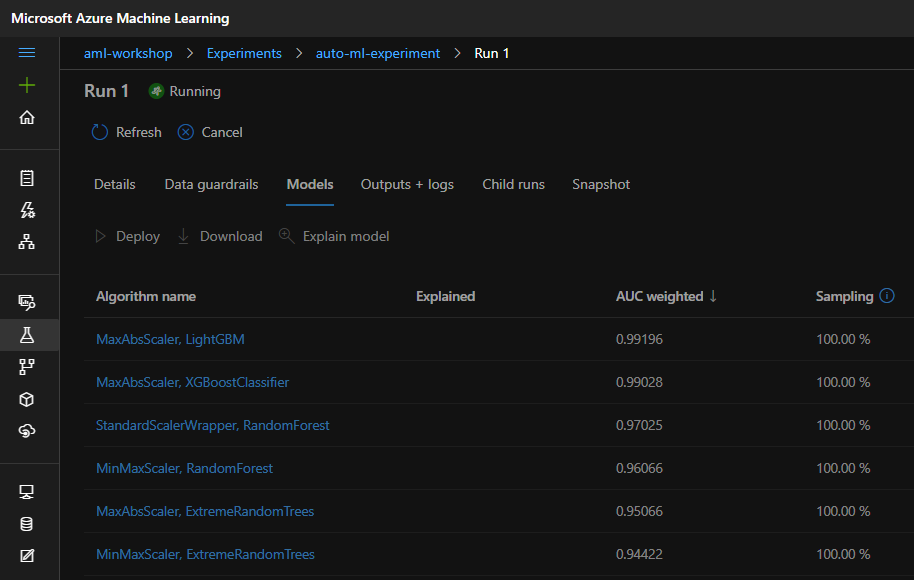

## Выбор лучшей модели

Давайте возьмем лучший прогон и обученную в процессе прогона модель.

In [ ]:
import sklearn.impute
from sklearn.impute import *

best_run, best_model = run.get_output()
print(best_run)
print(best_model)

best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, metric)

Auto ML включает в себя возможность попробовать предварительную обработку данных, которая выполняется с помощью конвейеров преобразования Scikit-Learn (не путать с Конвейерами машинного обучения Azure!). Они создают модели, которые включают в себя шаги по преобразованию данных перед выводом. Вы можете просмотреть шаги в такой модели, как эта:

In [ ]:
for step in best_model.named_steps:
    print(step)

Зарегистрируем лучшую ML модель:

In [ ]:
best_run.register_model(model_path='outputs/model.pkl', 
                        model_name=config['core']['ml_model_name'],
                        tags={'Lab':'8B'},
                        properties={'AUC': best_run_metrics['AUC_weighted'], 'Accuracy': best_run_metrics['accuracy']})

Просмотрим список зарегистрированных моделей:

In [ ]:
for model in Model.list(ws):
    print(f'{model.name} v{model.version}')
    
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print(f'\t {tag_name}: {tag}')
        
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print(f'\t {prop_name}: {prop}')

## Полезные ссылки

1. https://docs.microsoft.com/ru-ru/azure/machine-learning/how-to-configure-auto-train